In [6]:
import pandas as pd
import numpy as np
import time
import requests
import matplotlib.pyplot as plt
import terminalLogic
from terminalLogic import Algo
import client
from client import engine
from typing import Optional, Dict, Any, List
from requests import Request, Session, Response
import sys
import hmac
import urllib.parse
import json
import plotly.graph_objects as go
from datetime import datetime
plt.rcParams["figure.figsize"] = (30,10)


In [7]:
data = engine.getData('BTCPERP')
df = Algo.fullstate(data,data)
df

,time,open,high,low,close,volume,9-min,21-min,signal,market_returns,trend_returns,entry,ma,ratio,position,entryR,range_returns,sign
21,2021-10-31 22:43:00,61362.0,61387.0,61362.0,61378.0,84613.1336,61389.333333,61477.095238,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,2021-10-31 22:44:00,61378.0,61399.0,61378.0,61399.0,34381.9670,61380.555556,61467.190476,-1.0,0.000342,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
23,2021-10-31 22:45:00,61399.0,61405.0,61362.0,61370.0,177368.7391,61374.444444,61459.952381,-1.0,-0.000472,-0.000342,0.0,NaN,NaN,NaN,NaN,NaN,NaN
24,2021-10-31 22:46:00,61370.0,61420.0,61370.0,61419.0,88592.8872,61371.888889,61447.714286,-1.0,0.000798,0.000472,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25,2021-10-31 22:47:00,61419.0,61450.0,61419.0,61441.0,111452.9479,61377.666667,61441.095238,-1.0,0.000358,-0.000798,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2021-11-01 23:17:00,61149.0,61149.0,61119.0,61123.0,52115.6180,61169.444444,61158.523810,1.0,-0.000425,0.000442,0.0,61169.444444,0.999241,-1.0,0.0,0.000425,1.0
1496,2021-11-01 23:18:00,61123.0,61145.0,61115.0,61121.0,64750.0840,61162.333333,61156.523810,1.0,-0.000033,-0.000425,0.0,61162.333333,0.999324,-1.0,0.0,0.000033,-1.0
1497,2021-11-01 23:19:00,61121.0,61132.0,61110.0,61120.0,63165.8276,61154.111111,61155.000000,-1.0,-0.000016,0.000033,-2.0,61154.111111,0.999442,-1.0,0.0,0.000016,1.0
1498,2021-11-01 23:20:00,61120.0,61131.0,61109.0,61110.0,93622.1544,61151.000000,61153.904762,-1.0,-0.000164,0.000016,0.0,61151.000000,0.999330,-1.0,0.0,0.000164,-1.0


C:\Users\tbrid\Desktop\terminalLogic\code\terminalLogic.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self['rangeSign'] = np.where(self['range_returns'] < 0, 'neg','pos')
C:\Users\tbrid\Desktop\terminalLogic\code\terminalLogic.py:300: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self['trendSign'] = np.where(self['trend_returns'] < 0, 'neg','pos')
C:\Users\tbrid\Desktop\terminalLogic\code\terminalLogic.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

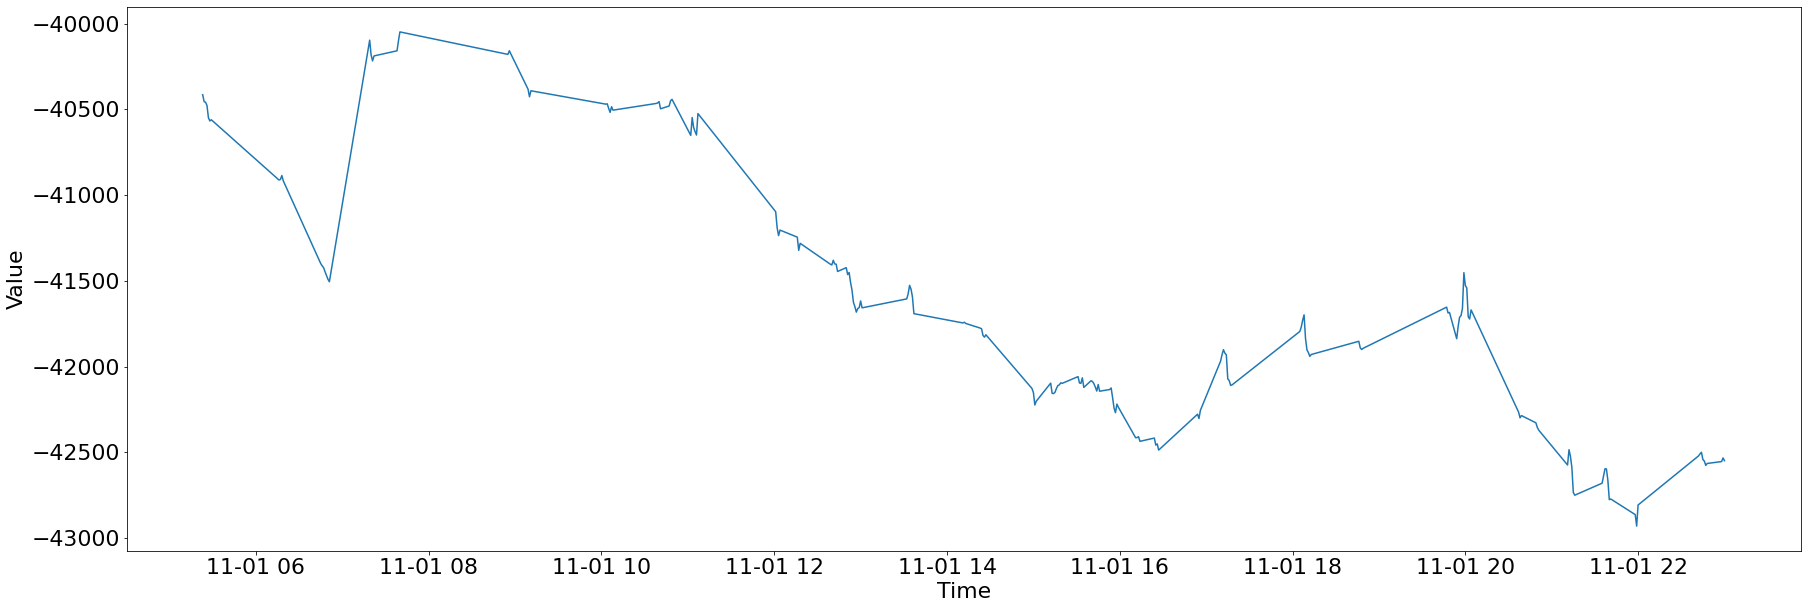

In [21]:
y = Algo.folio(df)
y

In [22]:
y['just_date'] = y['time'].dt.date
y['just_date']

TypeError: 'NoneType' object is not subscriptable

In [20]:
# Set initial capital
initial_capital = float(22000.0)

# Create df positions
positions = pd.DataFrame(index=y.time.index).fillna(0.0)


# Buy 2 BTC
positions['BTCPERP'] = 1*y['signal']

# Initilize portfolio w value owned
portfolio = positions.multiply(y['close'], axis=0)

# Store diff in shares owned
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(y['close'], axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(y['close'], axis=0)).sum(axis=1).cumsum()

# Add 'total' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add 'returns' to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

portfolio['time'] = y['time']
p = portfolio[-1:]
p.drop(columns=['time'], inplace=True)
p = p.reset_index(drop=True)
p.to_json('../web/templates/portfolio2.json', orient='records')
p

AttributeError: 'NoneType' object has no attribute 'index'

In [ ]:
fig = plt.figure(facecolor=(1, 1, 1))
x = portfolio.iloc[-200:]['time']
y = portfolio.iloc[-200:]['total']
plt.xticks(fontsize=22, color="black", rotate=90)
plt.xlabel('Time', color='black',fontsize=22)
plt.yticks(fontsize=22, color='black')
plt.ylabel('Value', color='black',fontsize=22)
plt.plot(values,y)
plt.savefig('../web/assets/portfolioStandings.png')
plt.show()

In [ ]:
portfolio.to_csv("../web/assets/portfolio")

In [10]:
# #column for negative and positive
# dfR=df.dropna()
# dfR['sign'] = np.where(dfR['range_returns'] < 0, 'neg','pos')
# dfT['sign'] = np.where(dfT['trend_returns'] < 0, 'neg','pos')

# #consecutive groups
# dfR['series'] = dfR['sign'].ne(dfR['sign'].shift()).cumsum()
# dfT['series'] = dfT['sign'].ne(dfT['sign'].shift()).cumsum()

# #removed groups with length more like 2
# df1 = dfR[dfR['series'].map(dfR['series'].value_counts()).gt(2)]
# df2 = dfT[dfT['series'].map(dfT['series'].value_counts()).gt(2)]

# #tested if order `pos-neg` of groups, if not removed groups
# m1 = df1['sign'].eq('pos') & df1['sign'].shift(-1).eq('neg')
# m2 = df1['sign'].eq('neg') & df1['sign'].shift().eq('pos')
# m3 = df2['sign'].eq('pos') & df2['sign'].shift(-1).eq('neg')
# m4 = df2['sign'].eq('neg') & df2['sign'].shift().eq('pos')
# groupsR = df1.loc[m1 | m2, 'series']
# df1 = df1[df1['series'].isin(groupsR)].copy()
# df1['pairs'] = (df1['sign'].ne(df1['sign'].shift()) & df1['sign'].eq('pos')).cumsum()
# groupsT = df2.loc[m3 | m4, 'series']
# df2 = df2[df2['series'].isin(groupsT)].copy()
# df2['pairs'] = (df2['sign'].ne(df2['sign'].shift()) & df2['sign'].eq('pos')).cumsum()
# rangeTradeCounts = df1['series'].nunique()
# trendTradeCounts = df2['series'].nunique()
# totalTrades = rangeTradeCounts + trendTradeCounts
# df1






# dfT=df.dropna()
# dfT['sign'] = np.where(dfT['trend_returns'] < 0, 'neg','pos')
# #consecutive groups
# dfT['series'] = dfT['sign'].ne(dfT['sign'].shift()).cumsum()
# #removed groups with length more like 2
# df2 = dfT[dfT['series'].map(dfT['series'].value_counts()).gt(2)]
# #tested if order `pos-neg` of groups, if not removed groups
# m3 = df2['sign'].eq('pos') & df2['sign'].shift(-1).eq('neg')
# m4 = df2['sign'].eq('neg') & df2['sign'].shift().eq('pos')
# groupsT = df2.loc[m3 | m4, 'series']
# df2 = df2[df2['series'].isin(groupsT)].copy()
# df2['pairs'] = (df2['sign'].ne(df2['sign'].shift()) & df2['sign'].eq('pos')).cumsum()
# rangeTradeCounts = df1['series'].nunique()
# trendTradeCounts = df2['series'].nunique()
# totalTrades = rangeTradeCounts + trendTradeCounts
# df1
# def traderets():
#     trades = df1['series'].nunique()
#     tradeValues = df1['range_returns'].sum()
#     valuePerTrade = df1.drop
# R = df['series'].dropna().nunique()
# W = len(df.loc[df.range_returns.dropna() > 0])
# L = len(df.loc[df.range_returns.dropna() < 0])
# P = 2*W*L

# Z_score = (N*(R-0.5)-P)/((P*(P-N))/(N-1))**(1/2)
# Z_score


### I need to sum all the values for each row in dataframe['range_returns'] where all of the values in dataframe['series'] are the same value. I would like to output a new df with columns ['seriesID', 'series_returns'].


### Thank you in advance

In [11]:
# dataframe = df1.filter(['just_date', 'close', 'range_returns', 'sign', 'series', 'pairs'], axis=1)
# # find % pos and neg trades
# dataframe.head(20)

In [12]:
# import re
# seriesRets = pd.DataFrame(columns=['seriesID', 'sign', 'seriesRets'])
# seriesRets['seriesRets'] = dataframe.groupby(['series', 'sign'])['range_returns'].transform('sum')
# seriesRets['seriesID'] = dataframe['series']
# seriesRets['sign'] = dataframe['sign']
# seriesRets = seriesRets.drop_duplicates()
# total = seriesRets['seriesRets'].sum()
# total = total.astype('float64')
# totes = float("{:.8f}".format(total))
# tradeCount = seriesRets['seriesID'].nunique()
# meanTrade = totes / tradeCount
# st_dev = seriesRets['seriesRets'].std()
# score = seriesRets['seriesRets'].values
# zScore = (score - meanTrade) / st_dev
# seriesRets['ZScore'] = zScore
# seriesRets['win_lose'] = np.where(seriesRets['sign'] == 'pos', 1, -1)
# winCount = []
# loseCount = []
# totalCount = []
# for win in seriesRets['win_lose']:
#     if win == 1:
#         winCount.append(1)
#         totalCount.append(len(winCount))
#     else:
#         loseCount.append(1)
#         totalCount.append(len(loseCount))
# seriesRets['tradeID'] = totalCount
# winners = seriesRets[seriesRets['win_lose']== 1]


In [13]:
# trade = {'Algo':['Range'],
#          'tradeCount':[tradeCount],
#          'total':[totes],
#          'mean':[meanTrade],
#          'st_dev':[st_dev],
#          'Zscore':[zScore]
#           }
# tradeDf = pd.DataFrame(trade)
# # seriesRets['win_lose'] = np.where(seriesRets['sign'] == 'pos', 1, -1)
# # seriesRets.groupby('sign').win_lose.value_counts().unstack()
# # winningTradeCount
# tradeDf

In [14]:
# newSeries = seriesRets[::-1]
# wins=0
# lose=0
# winCount = []
# loseCount = []
# totalCount = []
# for win in newSeries['win_lose']:
#     if win == 1:
#         wins+=1
#         winCount.append(wins)
#         loseCount.append(np.nan)
#     else:
#         lose+=1
#         loseCount.append(lose)
#         winCount.append(np.nan)
# newSeries['winningTradeID'] = winCount
# newSeries['losingTradeID'] = loseCount
# newSeries['winningTradeID'].max()
# overview = pd.DataFrame(columns=['TotalTradesTaken','WinningTrades',
#                                  'MaxWin', 'MinWin', 'LosingTrades',
#                                  'MaxLoss', 'MinLoss', 'ZScore',
#                                 'SharpeRatio', 'Win/LossRatio',
#                                 '30DayPnL'])
# overview['TotalTradesTaken'] = totalCount
# overview['LosingTrades'] = lose
# overview['WinningTrades'] = wins
# overview['MaxWin'] = newSeries['seriesRets'].max()
# overview['MaxLoss'] = newSeries['seriesRets'].min()



# overview

In [15]:
# overview = pd.DataFrame(columns=['TotalTradesTaken','WinningTrades',
#                                  'MaxWin', 'MinWin', 'LosingTrades',
#                                  'MaxLoss', 'MinLoss', 'ZScore',
#                                 'SharpeRatio', 'Win/LossRatio',
#                                 '30DayPnL'])
# overview['TotalTradesTaken'] = totalCount
# overview['LosingTrades'] = lose
# overview['WinningTrades'] = wins
# overview['MaxWin'] = newSeries['seriesRets'].max()
# overview['MaxLoss'] = newSeries['seriesRets'].min()



# overview

In [16]:
# maxwin = newSeries['seriesRets'].max()
# maxLoss = newSeries['seriesRets'].min()
# totesTaken = newSeries['seriesRets'].value_counts()
# numWin = newSeries['winningTradeID'].dropna().value_counts()
# numLoss = newSeries['losingTradeID'].dropna().value_counts()
# overview

In [17]:
# #column for negative and positive
# df.dropna()
# df['sign'] = np.where(df['trend_returns'] < 0, 'neg','pos')
# #consecutive groups
# df['series'] = df['sign'].ne(df['sign'].shift()).cumsum()
# #removed groups with length more like 2
# df1 = df[df['series'].map(df['series'].value_counts()).gt(2)]
# #tested if order `pos-neg` of groups, if not removed groups
# m1 = df1['sign'].eq('pos') & df1['sign'].shift(-1).eq('neg')
# m2 = df1['sign'].eq('neg') & df1['sign'].shift().eq('pos')
# groups = df1.loc[m1 | m2, 'series']
# df1 = df1[df1['series'].isin(groups)].copy()
# df1['pairs'] = (df1['sign'].ne(df1['sign'].shift()) & df1['sign'].eq('pos')).cumsum()

# A2 = len(groups)
# A3=A1+A2
# A3

In [ ]:
# portfolio.dropna().to_csv("../web/assets/portfolio.csv")

In [ ]:
# plt.plot(np.exp(df['returns'].tail(5000).dropna()).cumprod(), label='Buy/Hold')
# plt.plot(np.exp(df['strat_return'].tail(5000).dropna()).cumprod(), label='Strategy')
# plt.xticks(rotation=90)
# plt.legend();

In [ ]:
# # final value for each column

# print("Returns over time period specified within api call: ")
# marketR = np.exp(df['returns'].dropna()).cumprod().iloc[-1]-1
# stratR = np.exp(df['strat_return'].dropna()).cumprod().iloc[-1]-1
# percentageM = "{:.0%}".format(marketR)
# percentageS = "{:.0%}".format(stratR)
# print('Market: ', percentageM, 'Strat: ', percentageS)
# final value for each column
# print("Returns over time period specified within api call: ")
# print(np.exp(df['returns'].tail(5000).dropna()).cumprod().iloc[-1] -1)
# print(np.exp(df['strat_return'].tail(5000).dropna()).cumprod().iloc[-1] -1)